<a href="https://colab.research.google.com/github/nur-fatehah/ecoating/blob/main/E_coating_ultrafiltration_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing

In [ ]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
#import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

import seaborn as sns

In [ ]:
#load file, read file
from google.colab import files
upload = files.upload()

data_manual = pd.read_csv('manual_30min_norm.csv')
data_iiot = pd.read_csv('iiot_30min_norm.csv')

print(data_iiot)


Saving iiot_30min_norm.csv to iiot_30min_norm.csv
Saving manual_30min_norm.csv to manual_30min_norm.csv
          DATE            TIME       FM1       PE1       PE2       PE3  \
0    20/7/2020  20:30:00+00:00  0.495130  0.924763  0.948993  0.903162   
1    20/7/2020  20:00:00+00:00  0.495382  0.925821  0.952846  0.899702   
2    20/7/2020  19:30:00+00:00  0.483042  0.927908  0.953430  0.902238   
3    20/7/2020  19:00:00+00:00  0.494696  0.925443  0.952851  0.902522   
4    20/7/2020  18:30:00+00:00  0.509871  0.926097  0.954982  0.902386   
..         ...             ...       ...       ...       ...       ...   
715   5/7/2020  23:00:00+00:00  0.299610  0.950226  0.975747  0.916188   
716   5/7/2020  22:30:00+00:00  0.288927  0.950337  0.976253  0.915991   
717   5/7/2020  22:00:00+00:00  0.279458  0.944138  0.968994  0.912516   
718   5/7/2020  21:30:00+00:00  0.290384  0.947971  0.971459  0.913576   
719   5/7/2020  21:00:00+00:00  0.291841  0.944212  0.969845  0.909817   

       

Lets visualize our data first, to check if the data have any noise and need to be smoothened

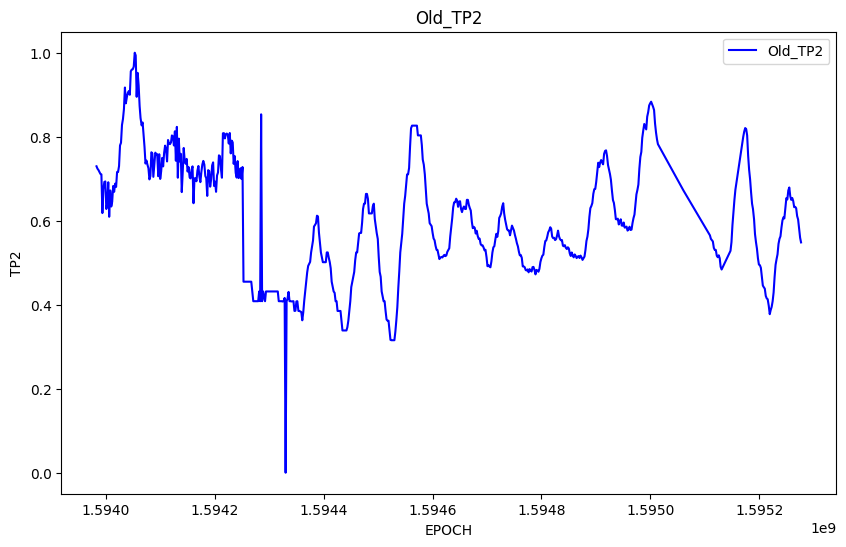

In [ ]:
#Plot to see TP2 trend
plt.figure(figsize=(10,6))
plt.plot(data_iiot['EPOCH'], data_iiot['TP2'], label='Old_TP2', color='blue')

plt.xlabel('EPOCH')
plt.ylabel('TP2')
plt.title('Old_TP2')
plt.legend()
plt.show()

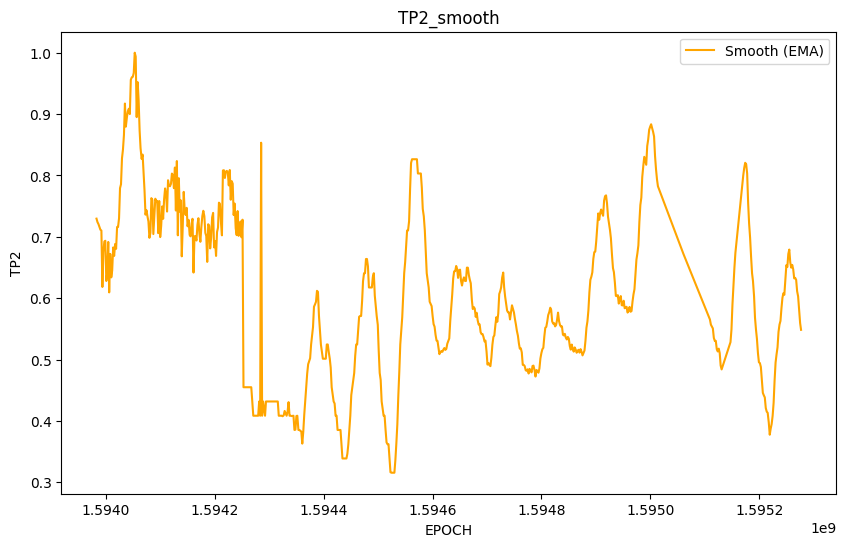

In [ ]:
#Smoothening the training graph of iiot_data using EMA and IQR
Q1 = data_iiot['TP2'].quantile(0.25)
Q3 = data_iiot['TP2'].quantile(0.75)
IQR = Q3-Q1

lower = Q1-1.5*IQR
upper = Q3+1.5*IQR

#remove sudden dips and spike
data_iiot = data_iiot[(data_iiot['TP2'] >= lower) & (data_iiot['TP2'] <= upper)]

#apply EMA for smoothening
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()
#descending values of TIME
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#Plot to see
plt.figure(figsize=(10,6))
plt.plot(data_iiot['EPOCH'], data_iiot['TP2'], label='Smooth (EMA)', color='orange')

plt.xlabel('EPOCH')
plt.ylabel('TP2')
plt.title('TP2_smooth')
plt.legend()
plt.show()

# EDA/Trend Analysis of all variables


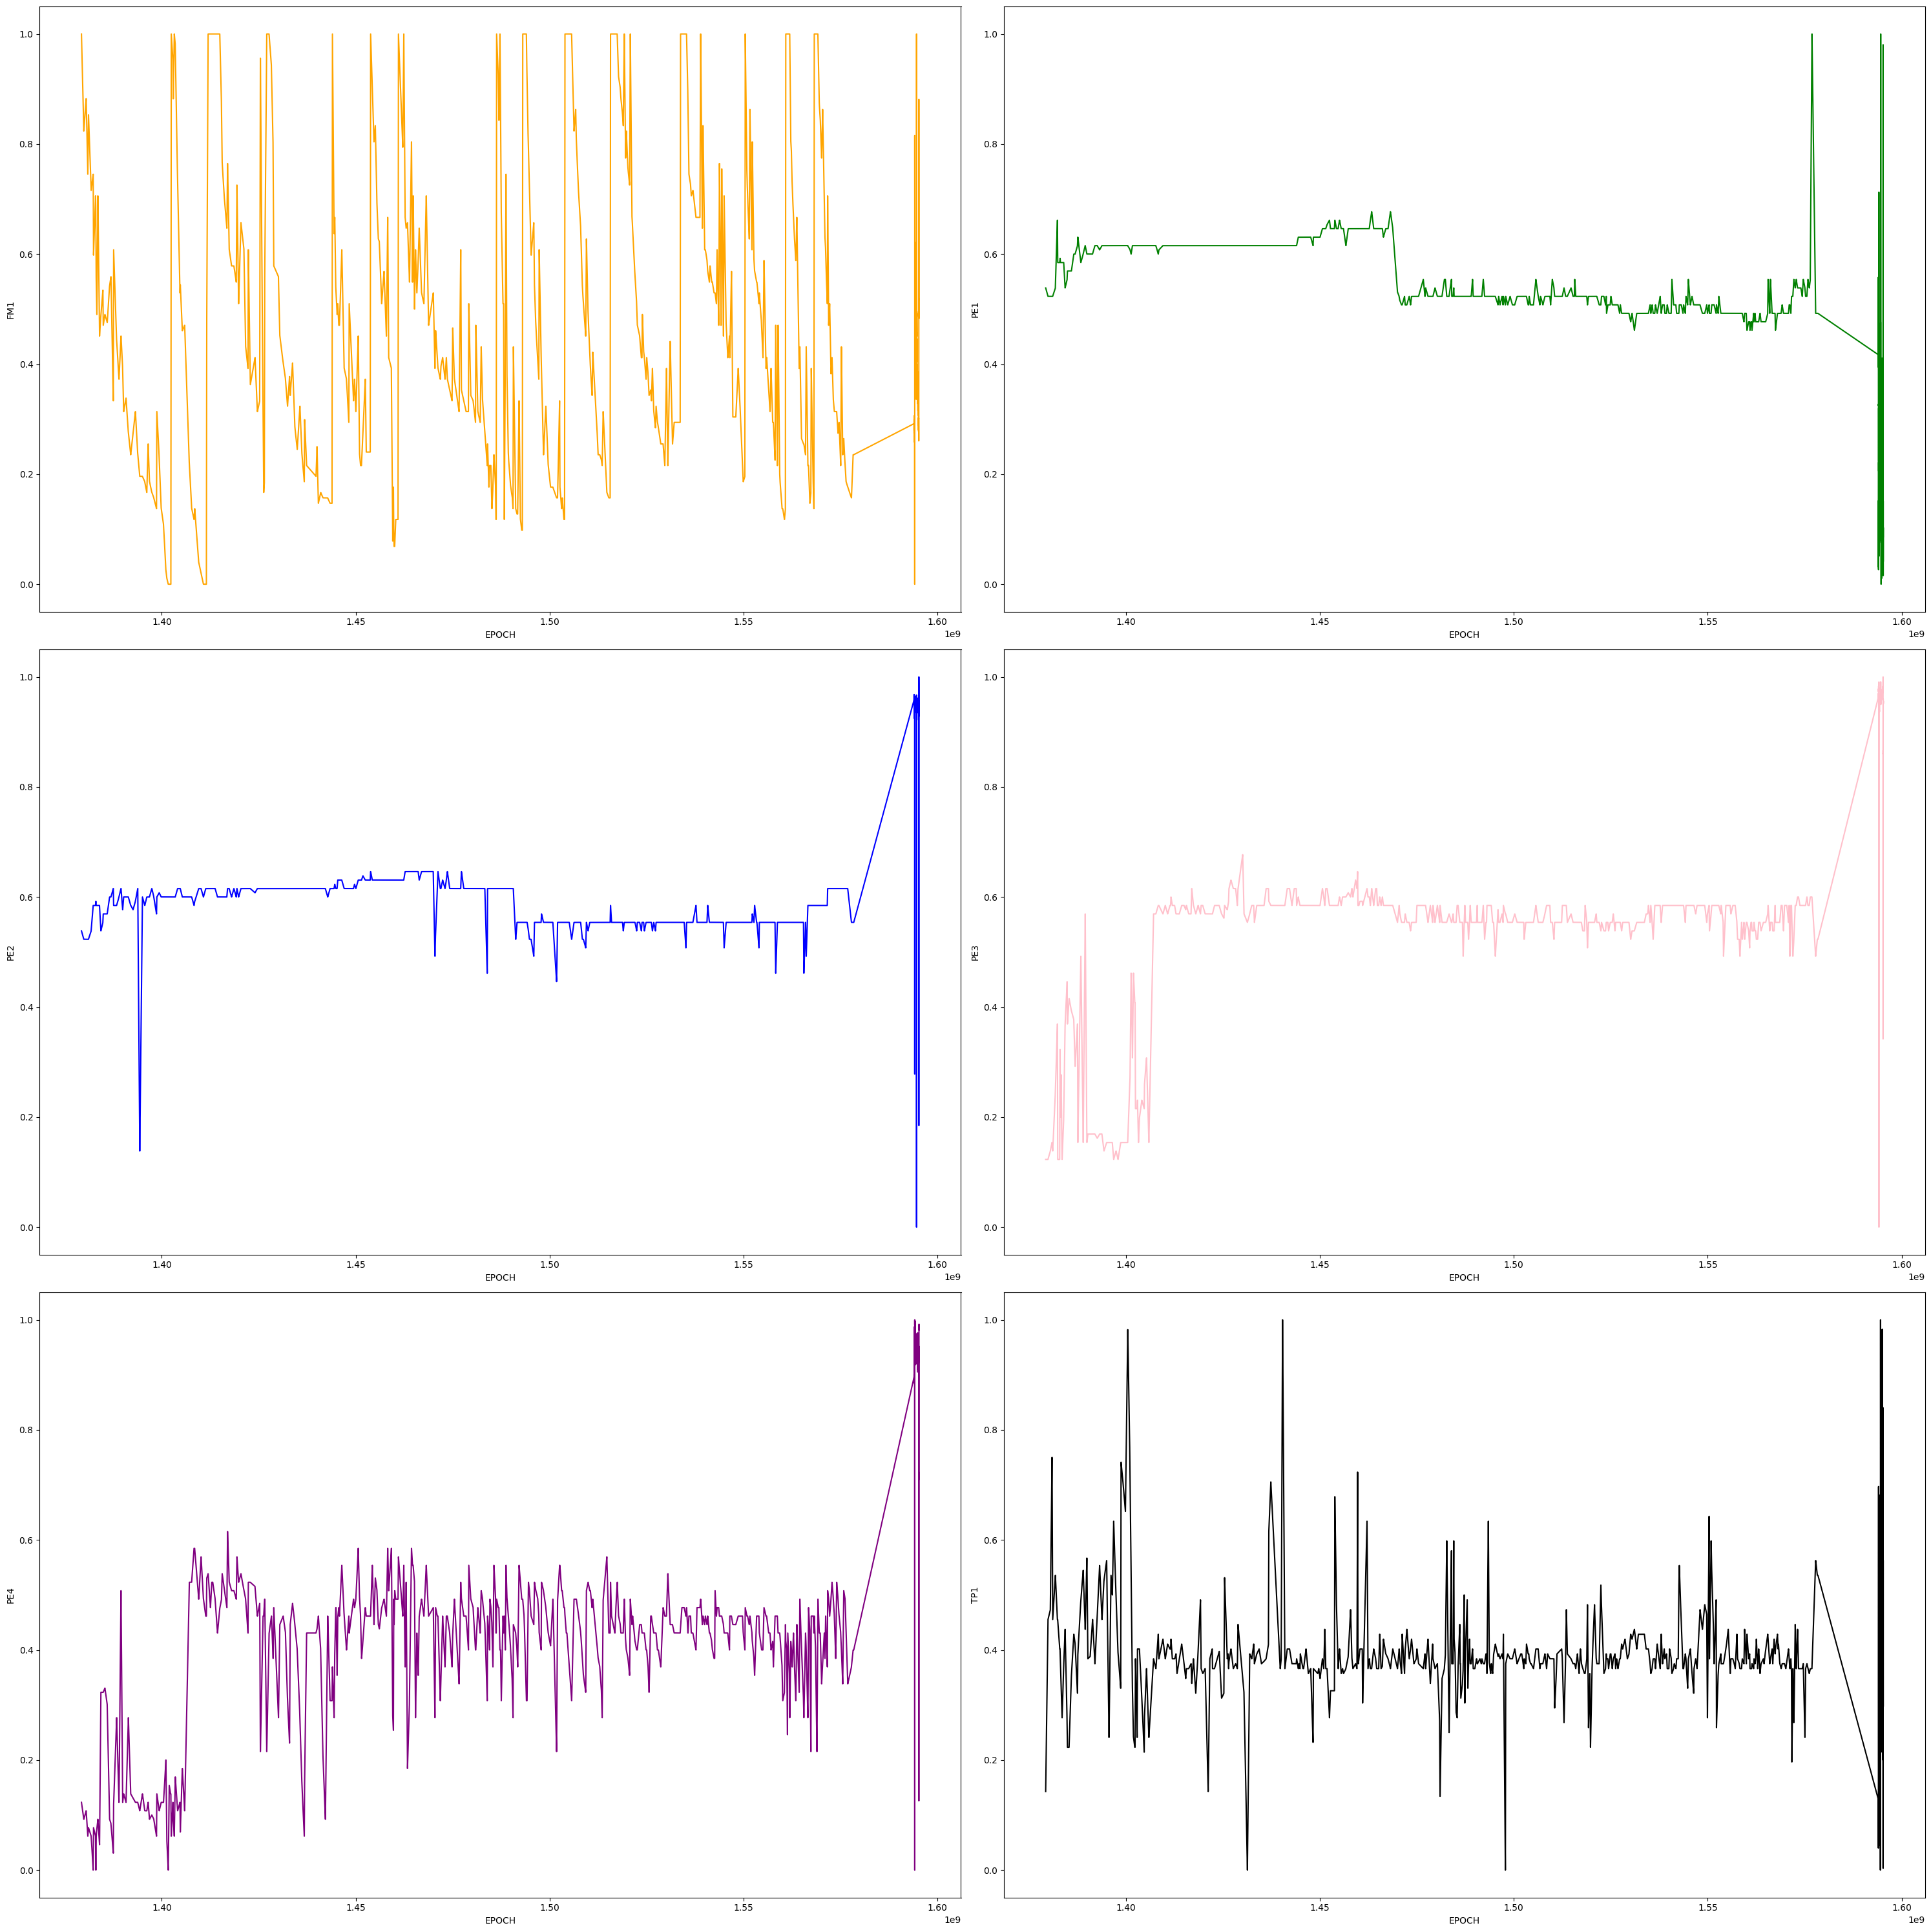

In [ ]:
#concat and create one big dataset
combine_data = pd.concat([data_manual, data_iiot])
combine_data = combine_data.sort_values(by='EPOCH', ascending=False)

#Plot to see
fig, axes = plt.subplots(3,2,figsize=(30,30))

axes[0,0].plot(combine_data['EPOCH'], combine_data['FM1'], label='FM1', color='orange')
axes[0,0].set_xlabel('EPOCH')
axes[0,0].set_ylabel('FM1')

axes[0,1].plot(combine_data['EPOCH'], combine_data['PE1'], label='PE1', color='green')
axes[0,1].set_xlabel('EPOCH')
axes[0,1].set_ylabel('PE1')

axes[1,0].plot(combine_data['EPOCH'], combine_data['PE2'], label='PE2', color='blue')
axes[1,0].set_xlabel('EPOCH')
axes[1,0].set_ylabel('PE2')

axes[1,1].plot(combine_data['EPOCH'], combine_data['PE3'], label='PE3', color='pink')
axes[1,1].set_xlabel('EPOCH')
axes[1,1].set_ylabel('PE3')

axes[2,0].plot(combine_data['EPOCH'], combine_data['PE4'], label='PE4', color='purple')
axes[2,0].set_xlabel('EPOCH')
axes[2,0].set_ylabel('PE4')

axes[2,1].plot(combine_data['EPOCH'], combine_data['TP1'], label='TP1', color='black')
axes[2,1].set_xlabel('EPOCH')
axes[2,1].set_ylabel('TP1')

plt.tight_layout()
plt.show()

Lets start with understanding correlation between data, and creating baseline to detect anomalies or outliers

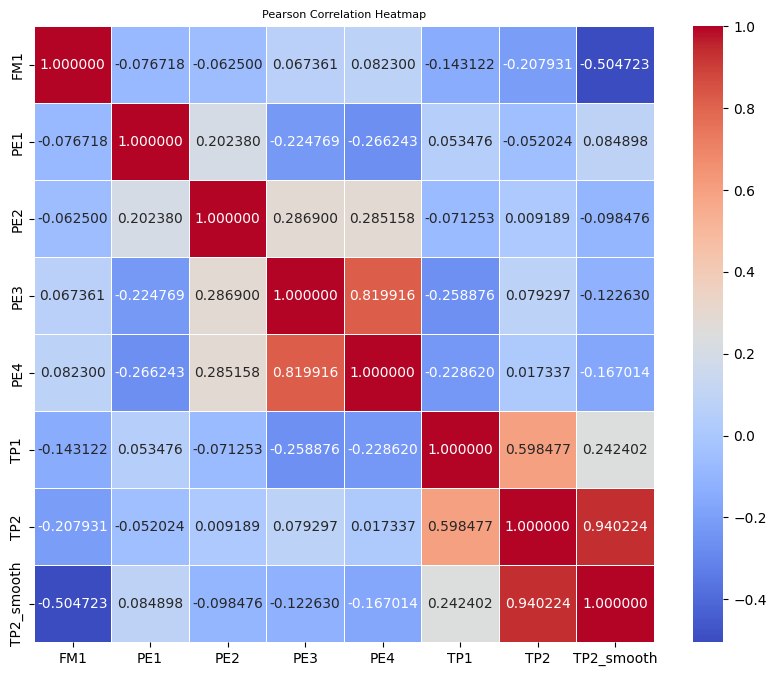

In [ ]:
corr_matrix = combine_data[['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1', 'TP2', 'TP2_smooth']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.6f', linewidths=0.5, cbar=True)
plt.title('Pearson Correlation Heatmap', fontsize=8)
plt.show()

We can conclude from heatmap that PE3 and PE4 have strong positive correlational relationship.

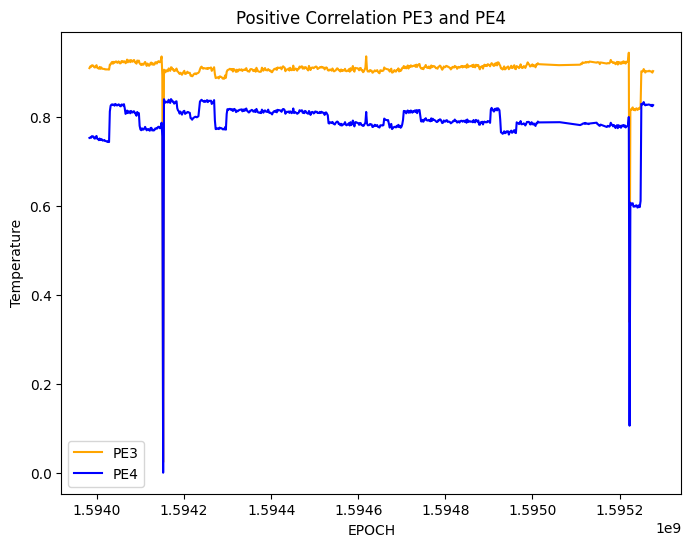

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(data_iiot['EPOCH'], data_iiot['PE3'], label='PE3', color='orange')
plt.plot(data_iiot['EPOCH'], data_iiot['PE4'], label='PE4', color='blue')
plt.xlabel('EPOCH')
plt.ylabel('Temperature')
plt.title('Positive Correlation PE3 and PE4')
plt.legend()
plt.show()

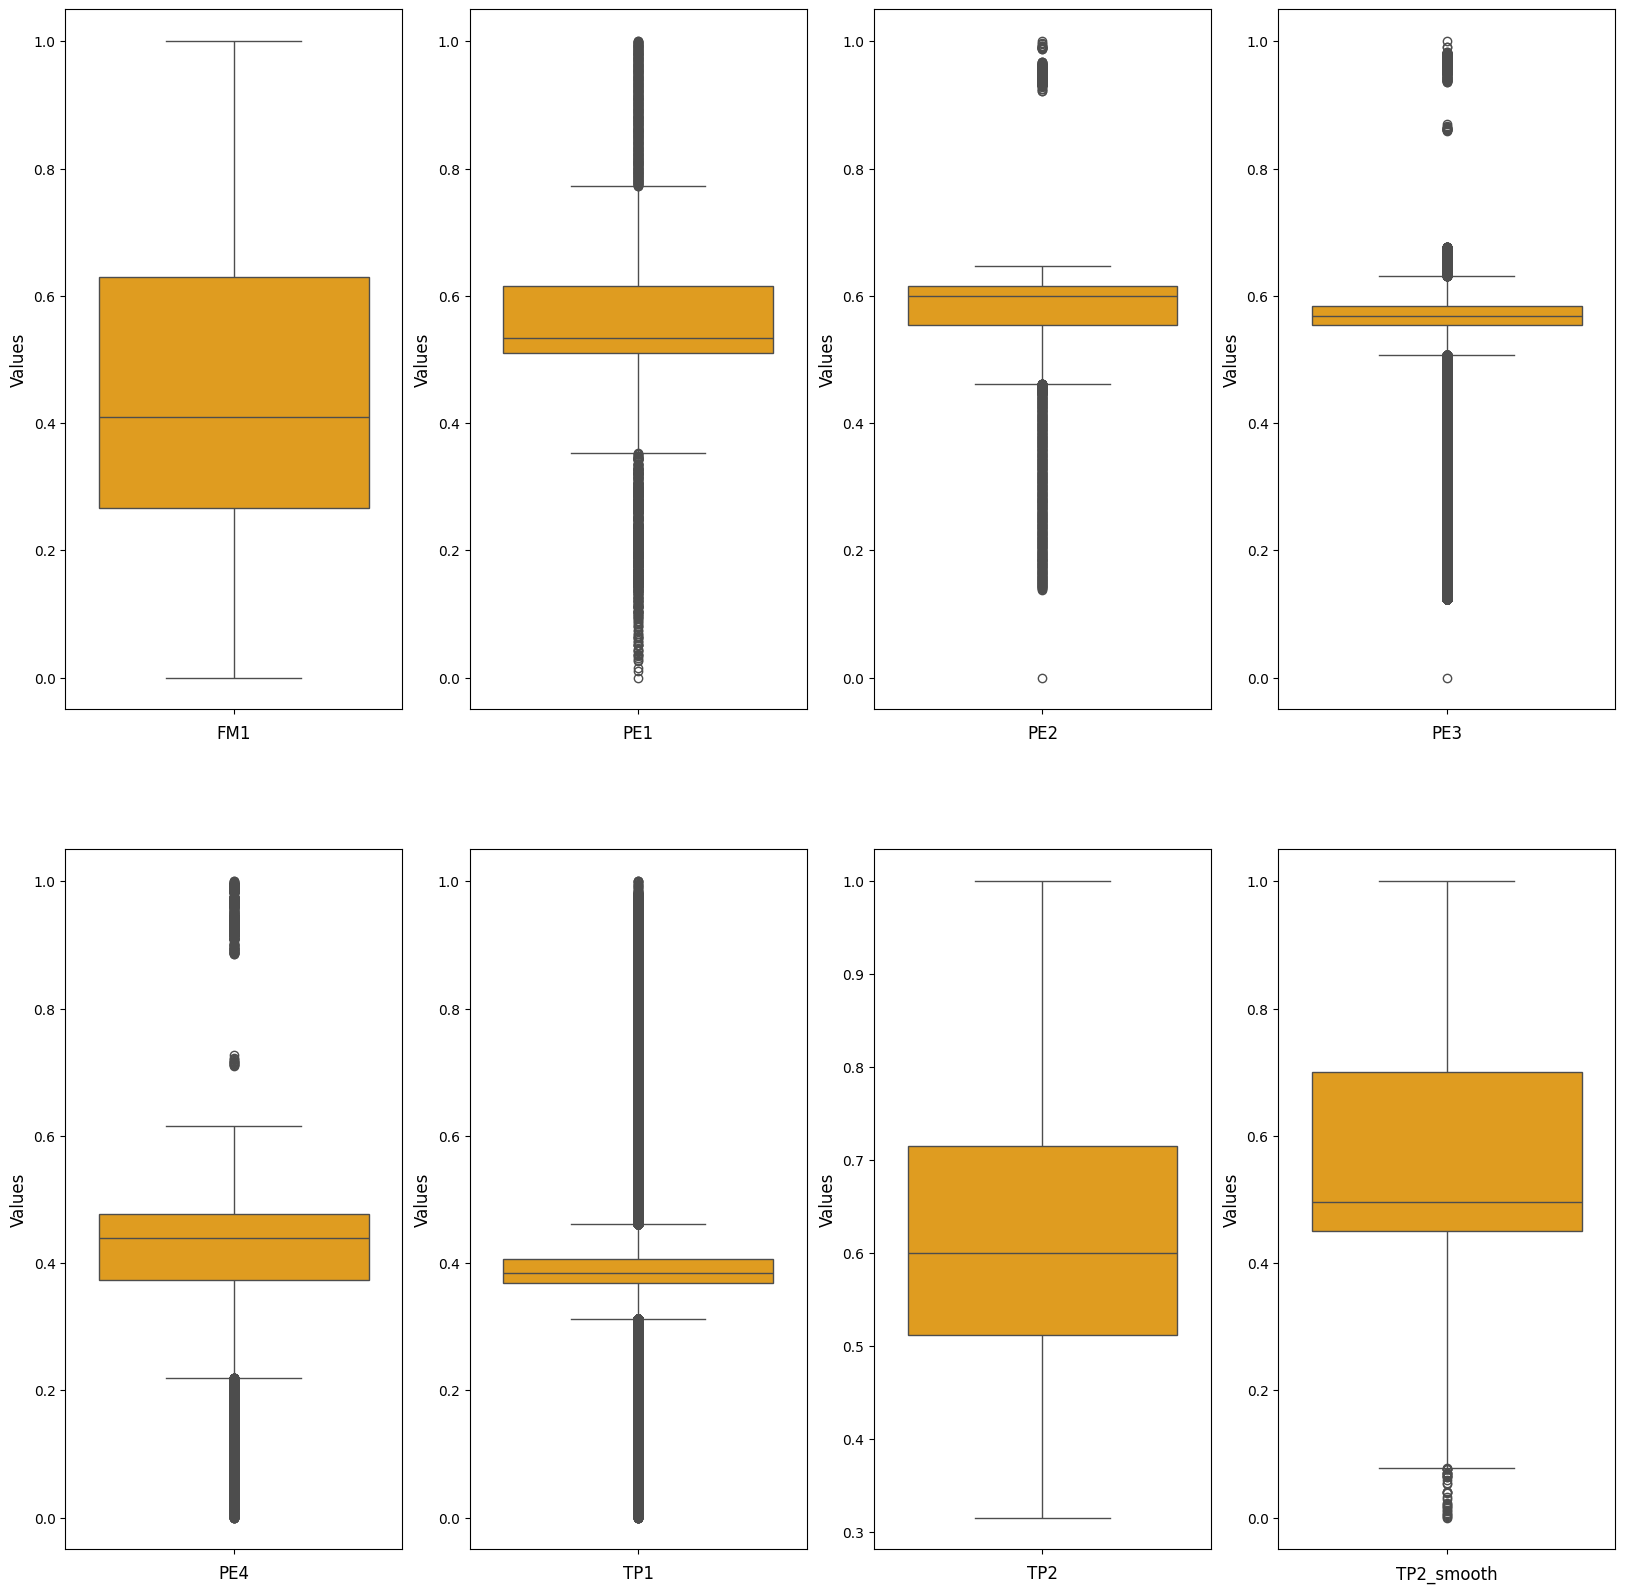

In [ ]:
#Plot to see
fig, axes = plt.subplots(2,4,figsize=(20,20))

# Plot the boxplot
sns.boxplot(data=combine_data['FM1'], ax=axes[0,0], color='orange')
axes[0,0].set_xlabel('FM1', fontsize=12)
axes[0,0].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['PE1'], ax=axes[0,1], color='orange')
axes[0,1].set_xlabel('PE1', fontsize=12)
axes[0,1].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['PE2'], ax=axes[0,2], color='orange')
axes[0,2].set_xlabel('PE2', fontsize=12)
axes[0,2].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['PE3'], ax=axes[0,3], color='orange')
axes[0,3].set_xlabel('PE3', fontsize=12)
axes[0,3].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['PE4'], ax=axes[1,0], color='orange')
axes[1,0].set_xlabel('PE4', fontsize=12)
axes[1,0].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['TP1'], ax=axes[1,1], color='orange')
axes[1,1].set_xlabel('TP1', fontsize=12)
axes[1,1].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['TP2'], ax=axes[1,2], color='orange')
axes[1,2].set_xlabel('TP2', fontsize=12)
axes[1,2].set_ylabel('Values', fontsize=12)

sns.boxplot(data=combine_data['TP2_smooth'], ax=axes[1,3], color='orange')
axes[1,3].set_xlabel('TP2_smooth', fontsize=12)
axes[1,3].set_ylabel('Values', fontsize=12)

# Show the plot
plt.show()


Lets check what are the outliers and the EPOCH

In [ ]:
#create function to detect outliers
def detect_outliers(data,column):
  Q1=data[column].quantile(0.25)
  Q3=data[column].quantile(0.75)
  IQR=Q3-Q1

  lower=Q1-1.5*IQR
  upper=Q3+1.5*IQR

  return data[(data[column]<lower) | (data[column]>upper)]

#Identify outliers
outliers_epoch_FM1 = detect_outliers(combine_data, 'EPOCH')
outliers_FM1 = detect_outliers(combine_data, 'FM1')

outliers_epoch_PE1 = detect_outliers(combine_data, 'EPOCH')
outliers_PE1 = detect_outliers(combine_data, 'PE1')

outliers_epoch_PE2 = detect_outliers(combine_data, 'EPOCH')
outliers_PE2 = detect_outliers(combine_data, 'PE2')

outliers_epoch_PE3 = detect_outliers(combine_data, 'EPOCH')
outliers_PE3 = detect_outliers(combine_data, 'PE3')

outliers_epoch_PE4 = detect_outliers(combine_data, 'EPOCH')
outliers_PE4 = detect_outliers(combine_data, 'PE4')

outliers_epoch_TP1 = detect_outliers(combine_data, 'EPOCH')
outliers_TP1 = detect_outliers(combine_data, 'TP1')

# Display the outliers
print(outliers_FM1[['FM1', 'EPOCH']])
print(f"Outliers cout: {outliers_FM1[['FM1', 'EPOCH']].shape[0]}\n")
print(outliers_PE1[['PE1', 'EPOCH']])
print(f"Outliers cout: {outliers_PE1[['PE1', 'EPOCH']].shape[0]}\n")
print(outliers_PE2[['PE2', 'EPOCH']])
print(f"Outliers cout: {outliers_PE2[['PE2', 'EPOCH']].shape[0]}\n")
print(outliers_PE3[['PE3', 'EPOCH']])
print(f"Outliers cout: {outliers_PE3[['PE3', 'EPOCH']].shape[0]}\n")
print(outliers_PE4[['PE4', 'EPOCH']])
print(f"Outliers cout: {outliers_PE4[['PE4', 'EPOCH']].shape[0]}\n")
print(outliers_TP1[['TP1', 'EPOCH']])
print(f"Outliers cout: {outliers_TP1[['TP1', 'EPOCH']].shape[0]}\n")

Empty DataFrame
Columns: [FM1, EPOCH]
Index: []
Outliers cout: 0

             PE1       EPOCH
0       0.042235  1595277000
1       0.062620  1595275300
2       0.102850  1595273300
3       0.055344  1595271600
4       0.067935  1595269800
...          ...         ...
109658  0.780641  1576674000
109657  0.778782  1576672300
109656  0.776923  1576670500
109655  0.775064  1576668500
109654  0.773205  1576666800

[999 rows x 2 columns]
Outliers cout: 999

           PE2       EPOCH
0     0.929445  1595277000
1     0.934773  1595275300
2     0.935581  1595273300
3     0.934780  1595271600
4     0.937729  1595269800
...        ...         ...
8161  0.454754  1393979400
8160  0.456410  1393977600
8159  0.458066  1393975800
8158  0.459722  1393974000
8157  0.461378  1393972200

[1281 rows x 2 columns]
Outliers cout: 1281

         PE3       EPOCH
0   0.955168  1595277000
1   0.951410  1595275300
2   0.954164  1595273300
3   0.954472  1595271600
4   0.954325  1595269800
..       ...         .

Lets identify the whiskers and set that as the upper and lower control limits

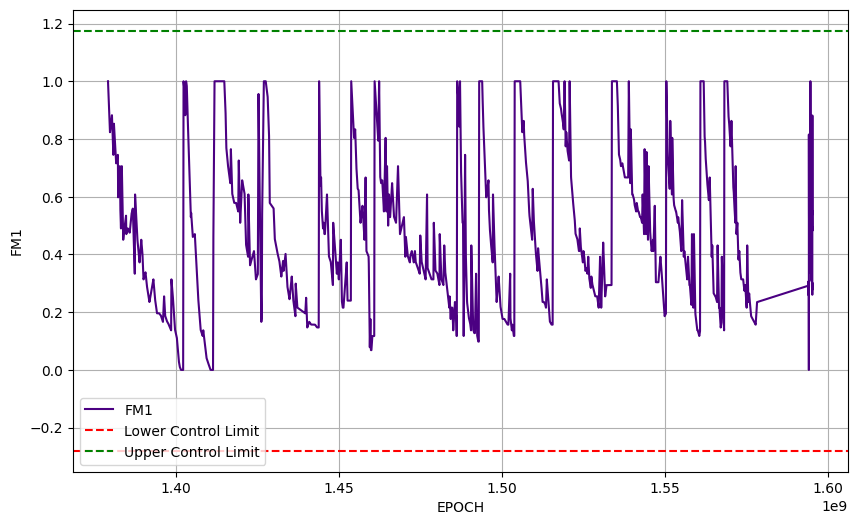

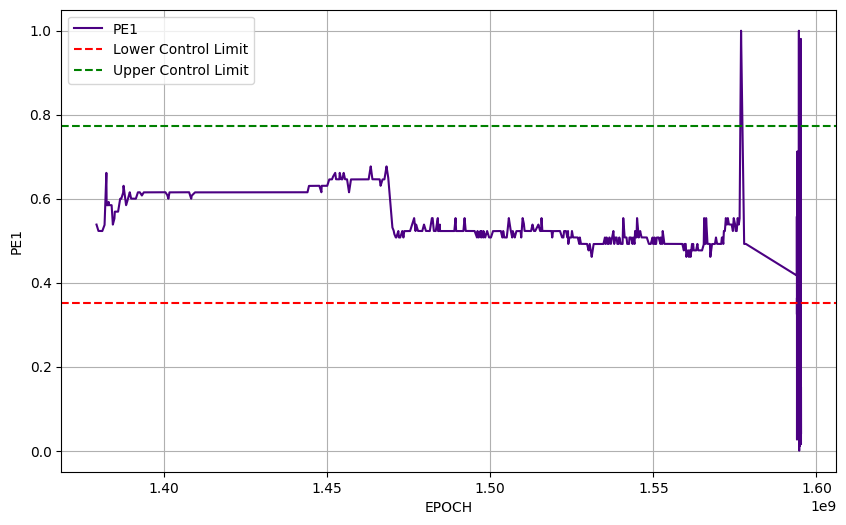

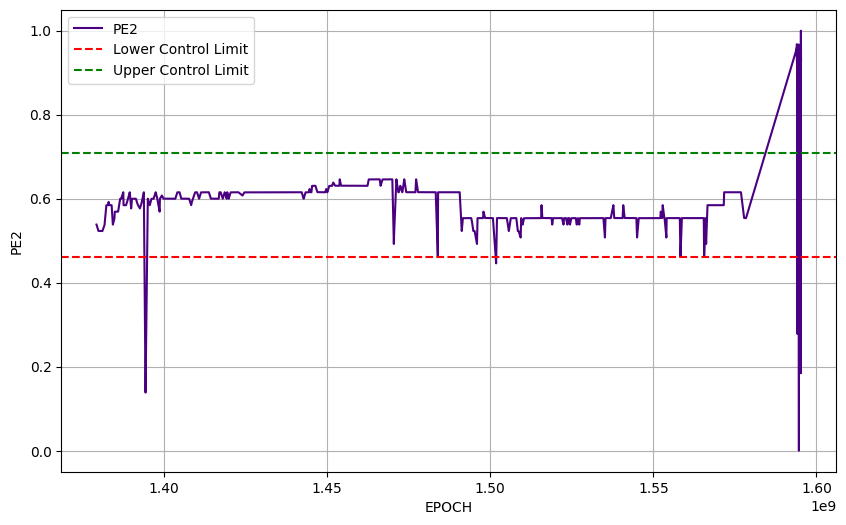

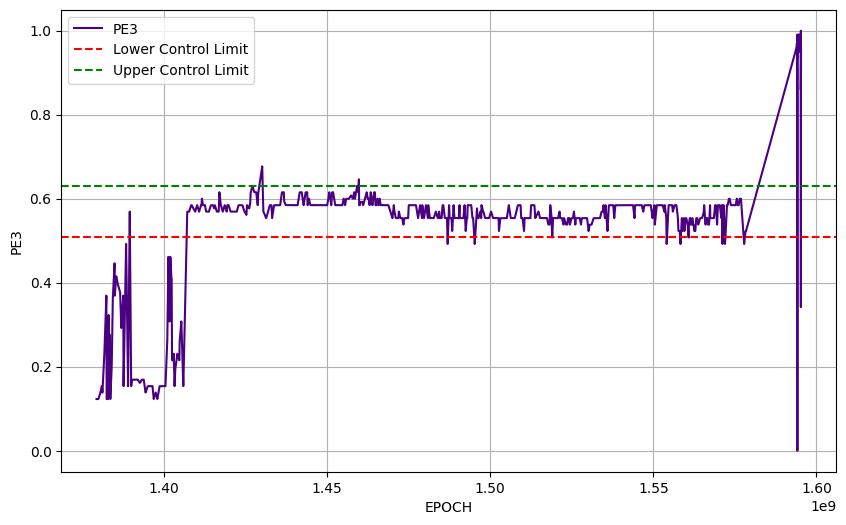

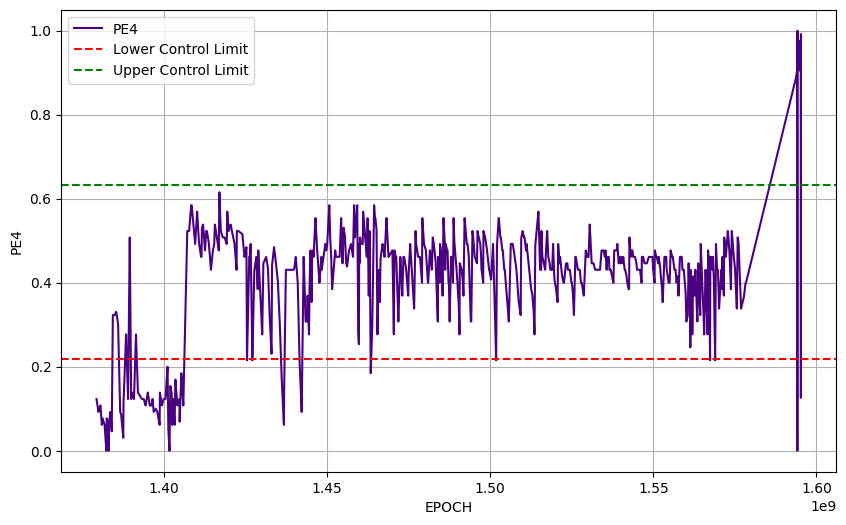

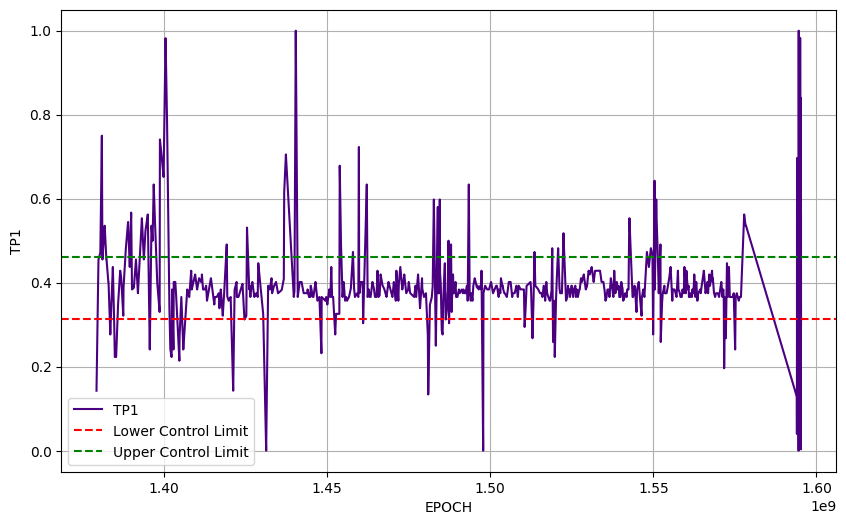

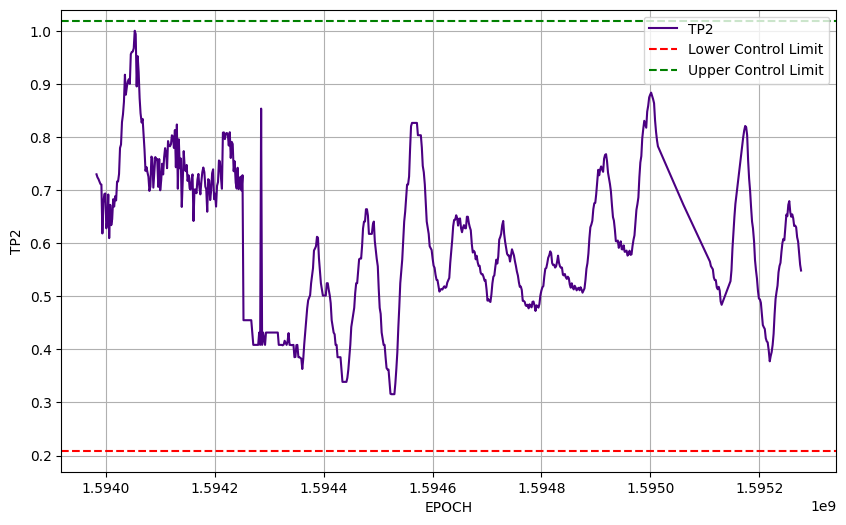

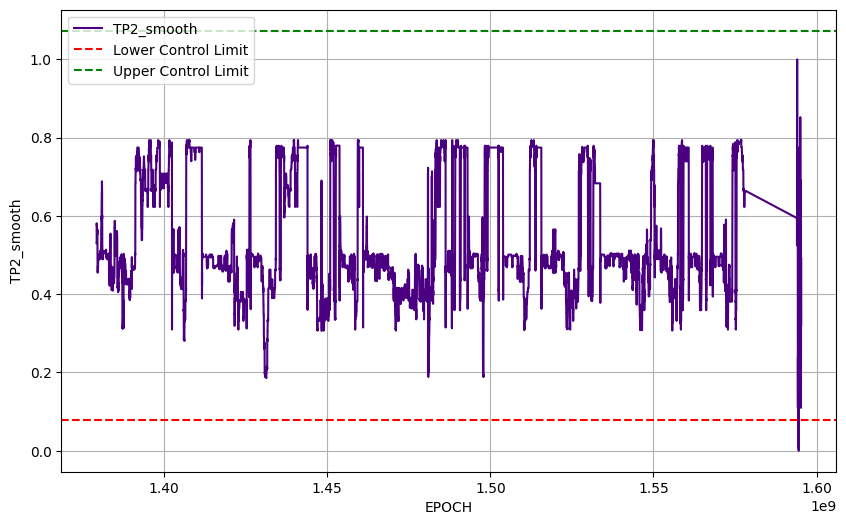

In [ ]:
#create function to get whiskers values
def detect_outliers(data,column):
  Q1=data[column].quantile(0.25)
  Q3=data[column].quantile(0.75)
  IQR=Q3-Q1

  lower=Q1-1.5*IQR
  upper=Q3+1.5*IQR

  return lower, upper

def plot_control_lims(data,column):
  lower, upper = detect_outliers(data,column)

  plt.figure(figsize=(10,6))
  plt.plot(data['EPOCH'], data[column], label=column, color='indigo')

  plt.axhline(y=lower, color='red', linestyle='--', label='Lower Control Limit')
  plt.axhline(y=upper, color='green', linestyle='--', label='Upper Control Limit')

  plt.xlabel('EPOCH')
  plt.ylabel(column)
  plt.legend()
  plt.grid(True)
  plt.show()

# Plot for each parameter
columns_to_plot = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1', 'TP2', 'TP2_smooth']
for col in columns_to_plot:
    plot_control_lims(combine_data, col)

Used control limit because UCL and LCL helps to determine process is in control or out of control. When data points fall outside of control limits, they are considered potential outliers and have to be investigated. Used Interquartile Range (IQR) to detect outliers. IQR focuses more on the middle (25% - 75%) data, hence less affected by outliers.

#TP2 forecasting data

Random Forest Regression

 MSE: 0.049086
 RMSE: 0.221553
 R2: -1.183239
 Mean Absolute Percentage Error %: 26.439392%

Bad model, RMSE 0.221553 bigger than 20%
Bad model, R2 -1.183239 is negative of less than 80%


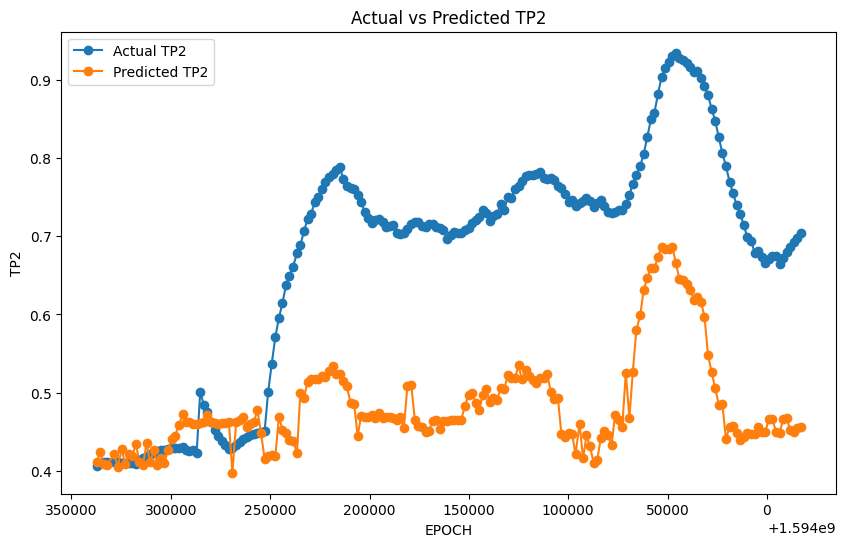

In [ ]:
#descending values of EPOCH
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#smoothened data
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()

# Drop rows where TP2 is missing
data_iiot = data_iiot.dropna(subset=['TP2_smooth'])

#Get data from specific time at column EPOCH
train_data = data_iiot[(data_iiot['EPOCH'] >= 1594339200) & (data_iiot['EPOCH'] <= 1595277000)]
test_data = data_iiot[(data_iiot['EPOCH'] >= 1593982800) & (data_iiot['EPOCH'] < 1594339200)]

#Define independent and dependant variables
independent = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
dependent = 'TP2_smooth'

#training and testing data random forest
x_train_random = train_data[independent]
y_train_random = train_data[dependent]

x_test_random = test_data[independent]
y_test_random = test_data[dependent]

#train random forest
modelrandomforest = RandomForestRegressor()
modelrandomforest.fit(x_train_random, y_train_random)

#predict TP2
y_predict_random = modelrandomforest.predict(x_test_random)

#calculate error matrics
mse_random = mean_squared_error(y_test_random, y_predict_random)
rmse_random = np.sqrt(mse_random)
r2_random = r2_score(y_test_random, y_predict_random)

#Calculate average error
epsilon = 1e-6
error = np.abs(y_test_random - y_predict_random) # absolute difference (all positive)
error_percent = (error/(y_test_random.replace(0,epsilon)))*100
mape_random = np.mean(error_percent)

print(f" MSE: {mse_random:.6f}\n RMSE: {rmse_random:.6f}\n R2: {r2_random:.6f}\n Mean Absolute Percentage Error %: {mape_random:.6f}%")

if rmse_random <= 0.2:
  print(f"\nModel is good, RMSE {rmse_random:.6f} less than 20%")
else:
    print(f"\nBad model, RMSE {rmse_random:.6f} bigger than 20%")

if r2_random >=0.8:
  print(f"Good model, R2 {r2_random:.6f} bigger than 80%")
else:
  print(f"Bad model, R2 {r2_random:.6f} is negative of less than 80%")

#plot predicted and actual as line graph
plt.figure(figsize=(10,6))
plt.plot(test_data['EPOCH'], y_test_random, label='Actual TP2', marker='o', linestyle='-')
plt.plot(test_data['EPOCH'], y_predict_random, label='Predicted TP2', marker='o', linestyle='-')
plt.xlabel('EPOCH')
plt.ylabel('TP2')
plt.title('Actual vs Predicted TP2')
plt.gca().invert_xaxis()  # Reverse x-axis
plt.legend()
plt.show()


LSTM TP2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 1, 50)               │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3094
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1047
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 16/50
33/33 ━

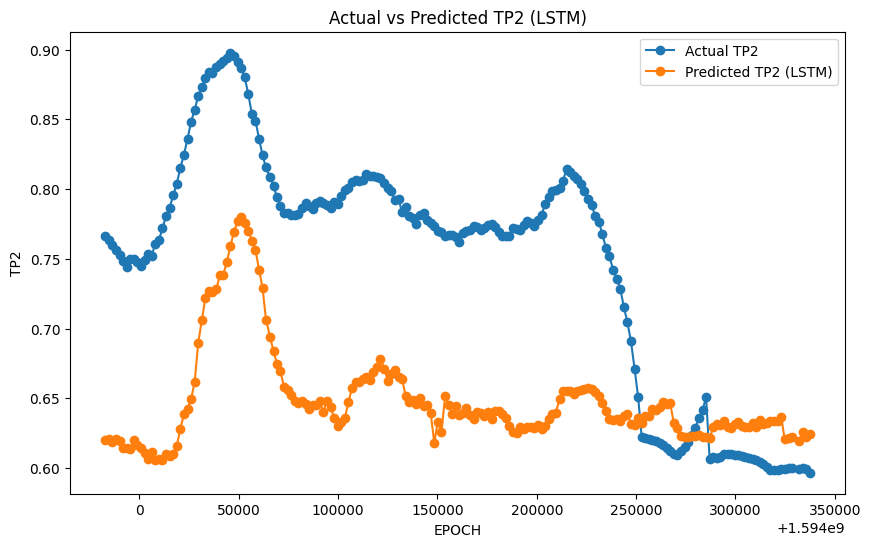

In [ ]:
#descending values of EPOCH
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#smoothened data
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()

# Drop rows where TP2 is missing
data_iiot = data_iiot.dropna(subset=['TP2_smooth'])

# Define independent and dependent variables
independent = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
dependent = 'TP2_smooth'

# Normalize data
scaler = MinMaxScaler()
data_iiot[independent + [dependent]] = scaler.fit_transform(data_iiot[independent + [dependent]])

#Get data from specific time at column EPOCH
train_data_lstm = data_iiot[(data_iiot['EPOCH'] >= 1594339200) & (data_iiot['EPOCH'] <= 1595277000)]
test_data_lstm = data_iiot[(data_iiot['EPOCH'] >= 1593982800) & (data_iiot['EPOCH'] < 1594339200)]

x_train_lstm, y_train_lstm = train_data_lstm[independent].values, train_data[dependent].values
x_test_lstm, y_test_lstm = test_data_lstm[independent].values, test_data[dependent].values

# Reshape input for LSTM: (samples, time steps, features)
x_train_lstm = x_train_lstm.reshape((x_train_lstm.shape[0], 1, x_train_lstm.shape[1]))
x_test_lstm = x_test_lstm.reshape((x_test_lstm.shape[0], 1, x_test_lstm.shape[1]))

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, len(independent))),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train model
model.fit(x_train_lstm, y_train_lstm, epochs=50, batch_size=16, verbose=1)

# Predict TP2
y_predict_lstm = model.predict(x_test_lstm)

# Inverse transform prediction
y_test_original_lstm = scaler.inverse_transform(np.hstack((x_test_lstm.reshape(x_test_lstm.shape[0], -1), y_test_lstm.reshape(-1, 1))))[:, -1]
y_predict_original_lstm = scaler.inverse_transform(np.hstack((x_test_lstm.reshape(x_test_lstm.shape[0], -1), y_predict_lstm.reshape(-1, 1))))[:, -1]

# Calculate error metrics
mse_lstm = mean_squared_error(y_test_original_lstm, y_predict_original_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_original_lstm, y_predict_original_lstm)

# Calculate average error %
epsilon = 1e-6
error = np.abs(y_test_original_lstm - y_predict_original_lstm)
error_percent = (error / (y_test_original_lstm + epsilon)) * 100
mape_lstm = np.mean(error_percent)

# Print results
print(f"\nMSE: {mse_lstm:.6f}\n RMSE: {rmse_lstm:.6f}\n R²: {r2_lstm:.6f}\n Mean Absolute Percentage Error %: {mape_lstm:.6f}%")

if rmse_lstm <= 0.2:
  print(f"\nModel is good, RMSE {rmse_lstm:.6f} less than 20%")
else:
    print(f"\nBad model, RMSE {rmse_lstm:.6f} bigger than 20%")

if r2_lstm >=0.8:
  print(f"Good model, R2 {r2_lstm:.6f} bigger than 80%")
else:
  print(f"Bad model, R2 {r2_lstm:.6f} less than 80% or negative\n")

# Plot actual vs predicted TP2
plt.figure(figsize=(10, 6))
plt.plot(test_data['EPOCH'], y_test_original_lstm, label='Actual TP2', marker='o', linestyle='-')
plt.plot(test_data['EPOCH'], y_predict_original_lstm, label='Predicted TP2 (LSTM)', marker='o', linestyle='-')
plt.xlabel('EPOCH')
plt.ylabel('TP2')
plt.title('Actual vs Predicted TP2 (LSTM)')
plt.legend()
plt.show()


XGBoost ML Regression TP2


 MSE: 0.045205
 RMSE: 0.212616
 R²: -1.010654
 Mean Absolute Percentage Error %: 25.496746%

Bad model, RMSE 0.212616 bigger than 20%
Bad model, R2 -1.010654 less than 80% or negative



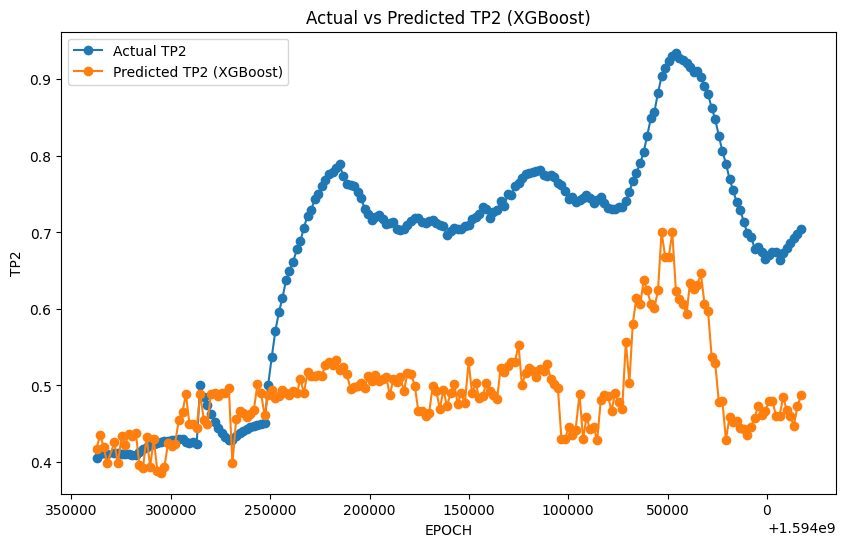

In [ ]:
#descending values of EPOCH
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#smoothened data
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()

# Drop rows where TP2 is missing
data_iiot = data_iiot.dropna(subset=['TP2_smooth'])

# Define independent and dependent variables
independent = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
dependent = 'TP2_smooth'

# Normalize data
scaler = MinMaxScaler()
data_iiot[independent + [dependent]] = scaler.fit_transform(data_iiot[independent + [dependent]])

#Get data from specific time at column EPOCH
train_data_xgb = data_iiot[(data_iiot['EPOCH'] >= 1594339200) & (data_iiot['EPOCH'] <= 1595277000)]
test_data_xgb = data_iiot[(data_iiot['EPOCH'] >= 1593982800) & (data_iiot['EPOCH'] < 1594339200)]

x_train_xgb, y_train_xgb = train_data_xgb[independent].values, train_data_xgb[dependent].values
x_test_xgb, y_test_xgb = test_data_xgb[independent].values, test_data_xgb[dependent].values

# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(x_train_xgb, y_train_xgb)

# Predict TP2
y_predict_xgb = model_xgb.predict(x_test_xgb)

# Inverse transform prediction
y_test_original_xgb = scaler.inverse_transform(np.hstack((x_test_xgb, y_test_xgb.reshape(-1, 1))))[:, -1]
y_predict_original_xgb = scaler.inverse_transform(np.hstack((x_test_xgb, y_predict_xgb.reshape(-1, 1))))[:, -1]

# Calculate error metrics
mse_xgb = mean_squared_error(y_test_original_xgb, y_predict_original_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original_xgb, y_predict_original_xgb)

# Calculate average error %
epsilon = 1e-6
error = np.abs(y_test_original_xgb - y_predict_original_xgb)
error_percent = (error / (y_test_original_xgb + epsilon)) * 100
mape_xgb = np.mean(error_percent)

# Print results
print(f"\n MSE: {mse_xgb:.6f}\n RMSE: {rmse_xgb:.6f}\n R²: {r2_xgb:.6f}\n Mean Absolute Percentage Error %: {mape_xgb:.6f}%")

if rmse_xgb <= 0.2:
  print(f"\nModel is good, RMSE {rmse_xgb:.6f} less than 20%")
else:
    print(f"\nBad model, RMSE {rmse_xgb:.6f} bigger than 20%")

if r2_xgb >=0.8:
  print(f"Good model, R2 {r2_xgb:.6f} bigger than 80%")
else:
  print(f"Bad model, R2 {r2_xgb:.6f} less than 80% or negative\n")

# Plot actual vs predicted TP2
plt.figure(figsize=(10, 6))
plt.plot(test_data['EPOCH'], y_test_original_xgb, label='Actual TP2', marker='o', linestyle='-')
plt.plot(test_data['EPOCH'], y_predict_original_xgb, label='Predicted TP2 (XGBoost)', marker='o', linestyle='-')
plt.xlabel('EPOCH')
plt.ylabel('TP2')
plt.title('Actual vs Predicted TP2 (XGBoost)')
plt.gca().invert_xaxis()  # Reverse x-axis
plt.legend()
plt.show()


We use RMSE, R2 and Mean Absolute Percentage Error to choose which model suits best. Generally, we take the highest R2 value, lowest RMSE value and lowest MAPE value.

In [ ]:
# we compare all RMSE for models
print(f"RMSE Random Forest: {rmse_random}, LSTM: {rmse_lstm}, XGB: {rmse_xgb}")
if rmse_random < rmse_lstm and rmse_random < rmse_xgb:
  print(f"Random Forest has lowest RMSE: {rmse_random}")
elif rmse_lstm < rmse_random and rmse_lstm < rmse_xgb:
  print(f"LSTM has lowest RMSE: {rmse_lstm}")
elif rmse_xgb < rmse_random and rmse_xgb < rmse_lstm:
  print(f"XGBoost has lowest RMSE: {rmse_xgb}")
elif rmse_random == rmse_lstm and rmse_random == rmse_xgb:
  print(f"All models have equal RMSE: {rmse_random}. This explains that the average deviation between predicted and actual values are the same across all models, but models are making different predictions")

# we compare all R2 for models
print(f"\nR2 Random Forest: {r2_random}, LSTM: {r2_lstm}, XGB: {r2_xgb}")
if r2_random > r2_lstm and r2_random > r2_xgb:
  print(f"Random Forest has closest to 1 R2 value: {r2_random}")
elif r2_lstm > r2_random and r2_lstm < r2_xgb:
  print(f"LSTM has closest to 1 R2 value: {r2_lstm}")
elif r2_xgb > r2_random and r2_xgb > r2_lstm:
  print(f"XGBoost has closest to 1 R2 value: {r2_xgb}")
elif r2_random == r2_lstm and r2_random == r2_xgb:
  print(f"All models have equal R2: {r2_random}. This explains that all models indicates better fit")

# we compare all MAPE
print(f"\nMAPE Random Forest: {mape_random}, LSTM: {mape_lstm}, XGB: {mape_xgb}")
if mape_random < mape_lstm and mape_random < mape_xgb:
  print(f"Random Forest has lowest MAPE: {mape_random}")
elif mape_lstm < mape_random and mape_lstm < mape_xgb:
  print(f"LSTM has lowest MAPE: {mape_lstm}")
elif mape_xgb < mape_random and mape_xgb < mape_lstm:
  print(f"XGBoost has lowest MAPE: {mape_xgb}")
elif mape_random == mape_lstm and mape_random == mape_xgb:
  print(f"All models have equal MAPE: {mape_random}. This explains that the average deviation between predicted and actual values are the same across all models, but models are making different predictions")


RMSE Random Forest: 0.22155285946513514, LSTM: 0.12184757024611922, XGB: 0.21261572072365698
LSTM has lowest RMSE: 0.12184757024611922

R2 Random Forest: -1.1832391347424944, LSTM: -1.0392927900945965, XGB: -1.0106539627659226
LSTM has closest to 1 R2 value: -1.0392927900945965

MAPE Random Forest: 26.43939217818747, LSTM: 13.987676106377267, XGB: 25.49674635436932
LSTM has lowest MAPE: 13.987676106377267


Forecast TP2 values of manual_data

In [ ]:
data_iiot.head()

,DATE,TIME,FM1,PE1,PE2,PE3,PE4,TP1,TP2,EPOCH,TP2_smooth
0,20/7/2020,20:30:00+00:00,0.495130,0.042235,0.929445,0.955168,0.983936,0.298095,0.548365,1595277000,0.548365
1,20/7/2020,20:00:00+00:00,0.495382,0.062620,0.934773,0.951410,0.980976,0.325662,0.559331,1595275300,0.550359
2,20/7/2020,19:30:00+00:00,0.483042,0.102850,0.935581,0.954164,0.984642,0.355604,0.584250,1595273300,0.556521
3,20/7/2020,19:00:00+00:00,0.494696,0.055344,0.934780,0.954472,0.982442,0.429196,0.602910,1595271600,0.564955
4,20/7/2020,18:30:00+00:00,0.509871,0.067935,0.937729,0.954325,0.984877,0.459539,0.611203,1595269800,0.573364


3458/3458 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


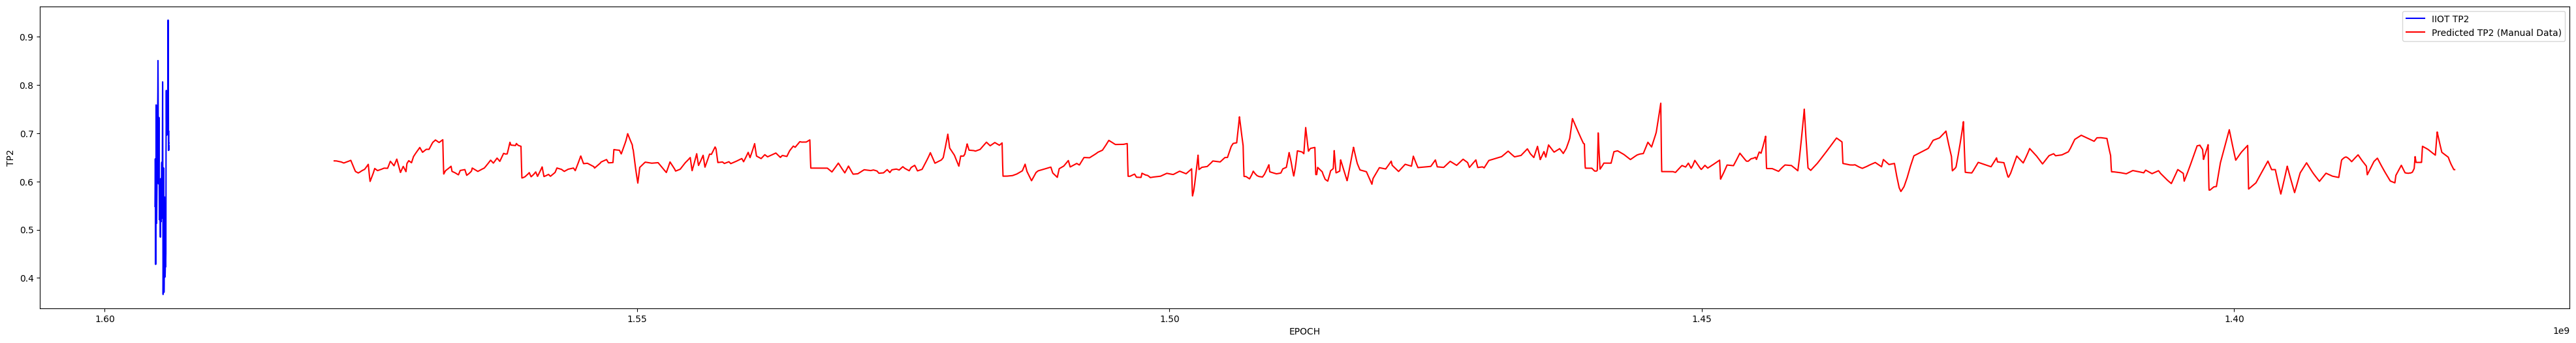

In [ ]:
# Ensure data_manual has independent features sorted by EPOCH
data_manual = data_manual.sort_values(by='EPOCH', ascending=False)

# Define independent and dependent variables
independent = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
dependent = 'TP2_smooth'

# Normalize data
scaler_x = MinMaxScaler() #independent
scaler_y = MinMaxScaler() #TP2_smooth
scaler_x.fit(data_iiot[independent])  # Fit only on independent variables
data_manual[independent] = scaler.transform(data_manual[independent])

# Fit the dependent scaler (only TP2_smooth)
scaler_y.fit(data_iiot[['TP2_smooth']])  # Fit on original TP2_smooth

# Reshape for LSTM input
x_manual_lstm = data_manual[independent].values.reshape((data_manual.shape[0], 1, len(independent)))

# Predict TP2 for data_manual
y_manual_pred = model.predict(x_manual_lstm)

# Inverse transform the predictions to original scale
y_manual_pred_original = scaler_y.inverse_transform(y_manual_pred)

# Store predictions in data_manual
data_manual['TP2_smooth'] = y_manual_pred_original

# Plot actual TP2 from data_iiot and predicted TP2 from data_manual
plt.figure(figsize=(50, 6))

# Plot actual TP2 from data_iiot
plt.plot(data_iiot['EPOCH'], data_iiot['TP2_smooth'], label='IIOT TP2', color='blue')

# Plot predicted TP2 from data_manual
plt.plot(data_manual['EPOCH'], data_manual['TP2_smooth'], label='Predicted TP2 (Manual Data)', color='red')

plt.xlabel('EPOCH')
plt.ylabel('TP2')
plt.gca().invert_xaxis()  # Reverse x-axis
plt.legend()
plt.show()

Save: Merge dataset into one updated dataset and save other data as new dataset

In [ ]:
#pd.concat() merge dataset according to header name, not header order
combined = pd.concat([data_manual, data_iiot])
combined = combined.sort_values(by='EPOCH', ascending=True)
combined.head()

#combined = combined.drop(columns=['TP2', 'DATE'])
#combined.head()

,TIME,FM1,PE1,PE2,PE3,PE4,TP1,EPOCH,TP2_smooth,DATE,TP2
0,16/9/2013 0:00,1.000000,0.538462,0.538462,0.123077,0.123077,0.142857,1379289600,0.530257,NaN,NaN
1,16/9/2013 0:30,0.999475,0.538416,0.538416,0.123077,0.122985,0.143787,1379291400,0.530257,NaN,NaN
2,16/9/2013 1:00,0.998950,0.538370,0.538370,0.123077,0.122894,0.144717,1379293200,0.530257,NaN,NaN
3,16/9/2013 1:30,0.998424,0.538324,0.538324,0.123077,0.122802,0.145647,1379295000,0.530257,NaN,NaN
4,16/9/2013 2:00,0.997899,0.538278,0.538278,0.123077,0.122711,0.146577,1379296800,0.581152,NaN,NaN


# Upstamp data forecasting for last 7 years

Random Forest Tree

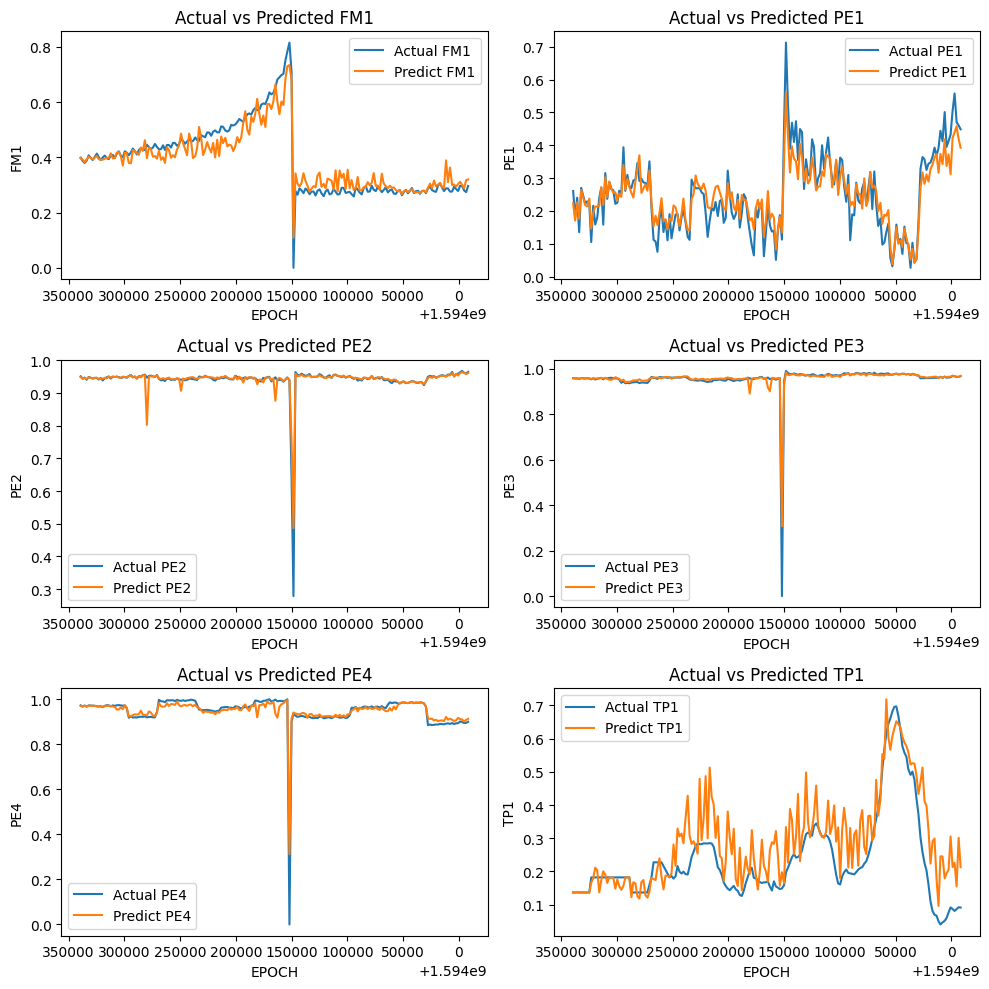


Metrics for FM1:
MSE: 0.001680
RMSE: 0.040984
R2: 0.899197
MAPE: 0.00000000000000000000%
Good model, RMSE 0.040984 less than or equal to 20%
Good model, R2 0.899197 bigger than or equal to 80%

Metrics for PE1:
MSE: 0.002004
RMSE: 0.044762
R2: 0.850908
MAPE: 0.00000000000000000000%
Good model, RMSE 0.044762 less than or equal to 20%
Good model, R2 0.850908 bigger than or equal to 80%

Metrics for PE2:
MSE: 0.000442
RMSE: 0.021029
R2: 0.843582
MAPE: 0.00000000000000000000%
Good model, RMSE 0.021029 less than or equal to 20%
Good model, R2 0.843582 bigger than or equal to 80%

Metrics for PE3:
MSE: 0.000560
RMSE: 0.023666
R2: 0.886168
MAPE: 0.00000000000000000000%
Good model, RMSE 0.023666 less than or equal to 20%
Good model, R2 0.886168 bigger than or equal to 80%

Metrics for PE4:
MSE: 0.000747
RMSE: 0.027323
R2: 0.871740
MAPE: 0.00000000000000000000%
Good model, RMSE 0.027323 less than or equal to 20%
Good model, R2 0.871740 bigger than or equal to 80%

Metrics for TP1:
MSE: 0.00916

In [ ]:
#descending values of EPOCH
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#smoothened data
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()

# Drop rows where TP2 is missing
data_iiot = data_iiot.dropna(subset=['TP2_smooth'])

#Get data from specific time at column EPOCH
train_data7 = data_iiot[(data_iiot['EPOCH'] >= 1593991800) & (data_iiot['EPOCH'] <= 1595277000)]
test_data7 = data_iiot[(data_iiot['EPOCH'] >= 1593991800) & (data_iiot['EPOCH'] <= 1594339200)]

#Define independent and dependant variables
dependent7 = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
independent7 = 'TP2_smooth'

#training and testing data random forest
x_train_random7 = train_data7[independent7].values.reshape(-1,1)
y_train_random7 = train_data7[dependent7]

x_test_random7 = test_data7[independent7].values.reshape(-1,1)
y_test_random7 = test_data7[dependent7]

#train random forest
modelrandomforest7 = RandomForestRegressor()
modelrandomforest7.fit(x_train_random7, y_train_random7)

#predict & convert to DF
y_predict_random7 = modelrandomforest7.predict(x_test_random7)
y_predict_random7 = pd.DataFrame(y_predict_random7, columns=dependent7)

#create dictionary for error metrics
mse_random7 = {}
rmse_random7 = {}
r2_random7 = {}
mape_random7 = {}
epsilon = 1e-6 #use small number to avoid division of 0

#plot dependent variables seperately
plt.figure(figsize=(10,10))

for i, target in enumerate(dependent7, 1):
  mse_random7[target] = mean_squared_error(y_test_random7[target], y_predict_random7[target])
  rmse_random7[target] = np.sqrt(mse_random7[target])
  r2_random7[target] = r2_score(y_test_random7[target], y_predict_random7[target])

  error7 = np.abs(y_test_random7[target] - y_predict_random7[target])
  error_percent7 = (error7/(y_test_random7[target]+epsilon)*100)
  # Ensure no NaN values in MAPE calculation
  mape_random7[target] = np.mean(error_percent7)
  mape_random7[target] = np.nan_to_num(np.mean(error_percent7), nan=0.0)


  # plot actual vs predicted
  plt.subplot(3,2,i)
  plt.plot(test_data7['EPOCH'], y_test_random7[target], label=f'Actual {target}')
  plt.plot(test_data7['EPOCH'], y_predict_random7[target], label=f'Predict {target}')
  plt.xlabel('EPOCH')
  plt.ylabel(target)
  plt.title(f'Actual vs Predicted {target}')
  plt.gca().invert_xaxis()  # Reverse x-axis
  plt.legend()

plt.tight_layout()
plt.show()

#Print error metrics
for target in dependent7:
  print(f'\nMetrics for {target}:')
  print(f'MSE: {mse_random7[target]:.6f}')
  print(f'RMSE: {rmse_random7[target]:.6f}')
  print(f'R2: {r2_random7[target]:.6f}')
  print(f'MAPE: {mape_random7[target]:.20f}%')

  if rmse_random7[target] <= 0.2:
    print(f"Good model, RMSE {rmse_random7[target]:.6f} less than or equal to 20%")
  else:
    print(f"Bad model, RMSE {rmse_random7[target]:.6f} bigger than 20%")
  if r2_random7[target] >= 0.8:
      print(f"Good model, R2 {r2_random7[target]:.6f} bigger than or equal to 80%")
  else:
    print(f"Bad model, R2 {r2_random7[target]:.6f} less than or equal to 80%")

LSTM 7 Years

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 1, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,906 (120.73 KB)

 Trainable params: 30,906 (120.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4999
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3499
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0937
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147
Epoch 16/50
45/45 ━

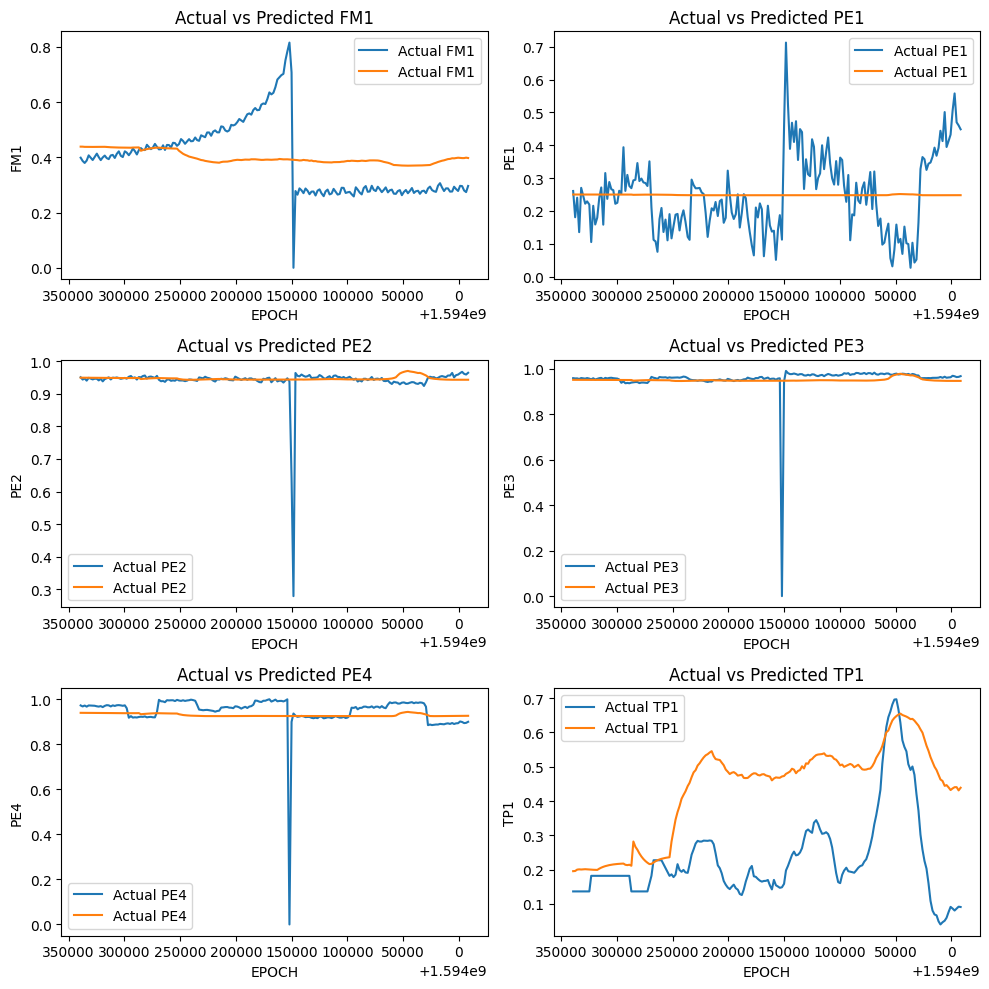


Metrics for FM1:
MSE: 0.015822
RMSE: 0.125785
R2: 0.050462
MAPE: 202597.462537%
Good model, RMSE 0.125785 is acceptable
Bad model, R2 0.050462 is not good

Metrics for PE1:
MSE: 0.013523
RMSE: 0.116287
R2: -0.006243
MAPE: 60.265486%
Good model, RMSE 0.116287 is acceptable
Bad model, R2 -0.006243 is not good

Metrics for PE2:
MSE: 0.002904
RMSE: 0.053887
R2: -0.027153
MAPE: 2.288452%
Good model, RMSE 0.053887 is acceptable
Bad model, R2 -0.027153 is not good

Metrics for PE3:
MSE: 0.004925
RMSE: 0.070182
R2: -0.001068
MAPE: 491023.544751%
Good model, RMSE 0.070182 is acceptable
Bad model, R2 -0.001068 is not good

Metrics for PE4:
MSE: 0.006058
RMSE: 0.077832
R2: -0.040798
MAPE: 479703.435335%
Good model, RMSE 0.077832 is acceptable
Bad model, R2 -0.040798 is not good

Metrics for TP1:
MSE: 0.057552
RMSE: 0.239899
R2: -2.266381
MAPE: 134.039390%
Bad model, RMSE 0.239899 is not good
Bad model, R2 -2.266381 is not good


In [ ]:
#descending values of EPOCH
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#smoothened data
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()

# Drop rows where TP2 is missing
data_iiot = data_iiot.dropna(subset=['TP2_smooth'])

# Define independent and dependent variables
dependent = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
independent = 'TP2_smooth'

# Normalize data
scaler = MinMaxScaler()
data_iiot[[independent] + dependent] = scaler.fit_transform(data_iiot[[independent] + dependent])

#Get data from specific time at column EPOCH
train_data_lstm7 = data_iiot[(data_iiot['EPOCH'] >= 1593991800) & (data_iiot['EPOCH'] <= 1595277000)]
test_data_lstm7 = data_iiot[(data_iiot['EPOCH'] >= 1593991800) & (data_iiot['EPOCH'] <= 1594339200)]

x_train_lstm7, y_train_lstm7 = train_data_lstm7[independent].values, train_data_lstm7[dependent].values
x_test_lstm7, y_test_lstm7 = test_data_lstm7[independent].values, test_data_lstm7[dependent].values

# Reshape input for LSTM: (samples, time steps, features)
x_train_lstm7 = x_train_lstm7.reshape(-1,1,1)
x_test_lstm7 = x_test_lstm7.reshape(-1,1,1)

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)),
    LSTM(50, activation='relu'),
    Dense(len(dependent)) #output layer should match no of dependent variables
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train model
model.fit(x_train_lstm7, y_train_lstm7, epochs=50, batch_size=16, verbose=1)

# Predict TP2
y_predict_lstm7 = model.predict(x_test_lstm7)

# Inverse transform prediction
y_test_original_lstm7 = scaler.inverse_transform(np.hstack((x_test_lstm7.reshape(x_test_lstm7.shape[0], -1), y_test_lstm7)))[:, 1:]
y_predict_original_lstm7 = scaler.inverse_transform(np.hstack((x_test_lstm7.reshape(x_test_lstm7.shape[0], -1), y_predict_lstm7)))[:, 1:]

# Calculate error metrics
mse_lstm7, rmse_lstm7, r2_lstm7, mape_lstm7 = {}, {}, {}, {}
epsilon = 1e-6

#plot dependent variables seperately
plt.figure(figsize=(10,10))

for i, target_lstm in enumerate(dependent):
  mse_lstm7[target_lstm] = mean_squared_error(y_test_original_lstm7[:,i], y_predict_original_lstm7[:, i])
  rmse_lstm7[target_lstm] = np.sqrt(mse_lstm7[target_lstm])
  r2_lstm7[target_lstm] = r2_score(y_test_original_lstm7[:,i], y_predict_original_lstm7[:, i])

  error7 = np.abs(y_test_original_lstm7[:,i] - y_predict_original_lstm7[:,i])
  error_percent7 = (error7 / (y_test_original_lstm7[:,i]+epsilon))*100
  mape_lstm7[target_lstm] = np.mean(error_percent7)

  #plot actual vs predicted
  plt.subplot(3,2,i+1)
  plt.plot(test_data_lstm7['EPOCH'], y_test_original_lstm7[:,i], label=f'Actual {target_lstm}')
  plt.plot(test_data_lstm7['EPOCH'], y_predict_original_lstm7[:,i], label=f'Actual {target_lstm}')
  plt.xlabel('EPOCH')
  plt.ylabel(target_lstm)
  plt.title(f'Actual vs Predicted {target_lstm}')
  plt.gca().invert_xaxis()  # Reverse x-axis
  plt.legend()

plt.tight_layout()
plt.show()

#print error metrics
for target_lstm in dependent:
  print(f'\nMetrics for {target_lstm}:')
  print(f'MSE: {mse_lstm7[target_lstm]:.6f}')
  print(f'RMSE: {rmse_lstm7[target_lstm]:.6f}')
  print(f'R2: {r2_lstm7[target_lstm]:.6f}')
  print(f'MAPE: {mape_lstm7[target_lstm]:.6f}%')

  if rmse_lstm7[target_lstm] <= 0.2:
    print(f"Good model, RMSE {rmse_lstm7[target_lstm]:.6f} is acceptable")
  else:
    print(f"Bad model, RMSE {rmse_lstm7[target_lstm]:.6f} is not good")
  if r2_lstm7[target_lstm] >= 0.8:
    print(f"Good model, R2 {r2_lstm7[target_lstm]:.6f} is acceptable")
  else:
    print(f"Bad model, R2 {r2_lstm7[target_lstm]:.6f} is not good")

XGBoost 7 Years

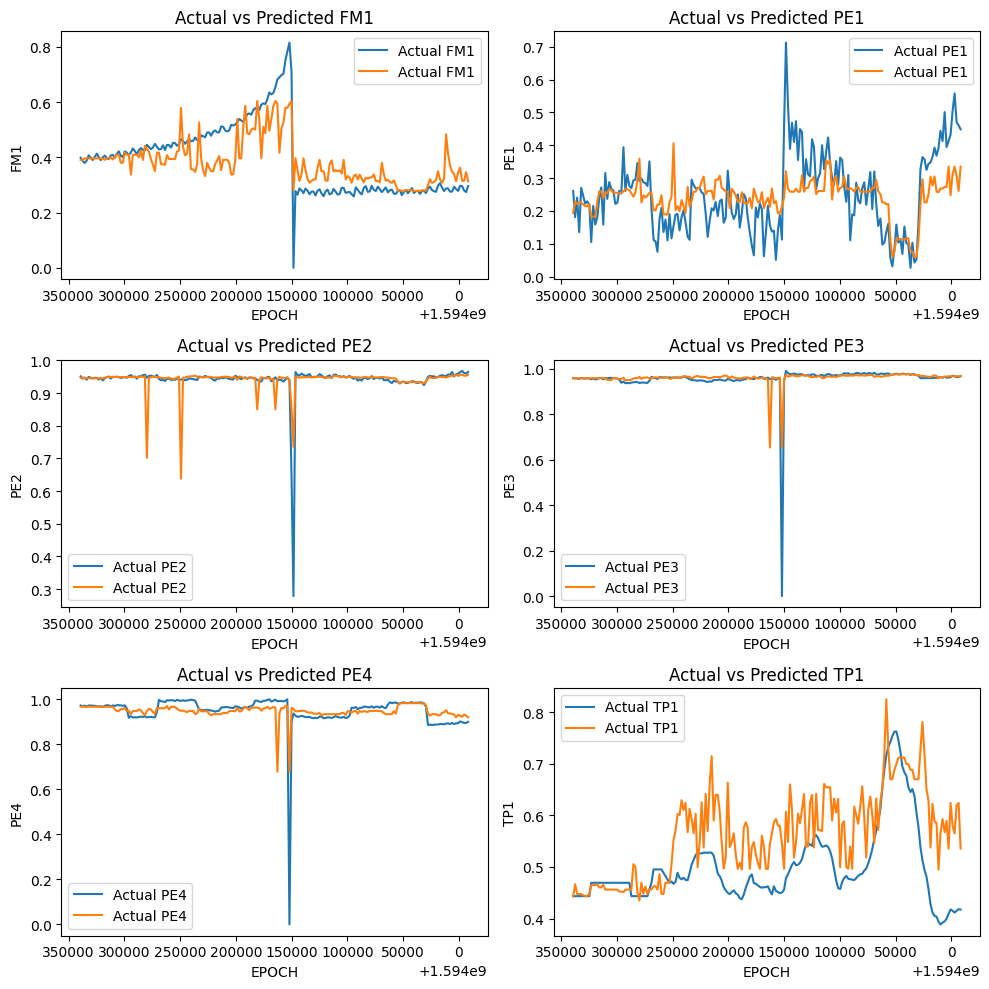


Metrics for FM1:
MSE: 0.006453
RMSE: 0.080329
R2: 0.612740
MAPE: 145574.047758%
Good model, RMSE 0.080329 is acceptable
Bad model, R2 0.612740 is not good

Metrics for PE1:
MSE: 0.008648
RMSE: 0.092993
R2: 0.356509
MAPE: 37.130599%
Good model, RMSE 0.092993 is acceptable
Bad model, R2 0.356509 is not good

Metrics for PE2:
MSE: 0.002218
RMSE: 0.047099
R2: 0.215324
MAPE: 1.849440%
Good model, RMSE 0.047099 is acceptable
Bad model, R2 0.215324 is not good

Metrics for PE3:
MSE: 0.002770
RMSE: 0.052628
R2: 0.437081
MAPE: 338756.554437%
Good model, RMSE 0.052628 is acceptable
Bad model, R2 0.437081 is not good

Metrics for PE4:
MSE: 0.003610
RMSE: 0.060086
R2: 0.379703
MAPE: 351469.566578%
Good model, RMSE 0.060086 is acceptable
Bad model, R2 0.379703 is not good

Metrics for TP1:
MSE: 0.009119
RMSE: 0.095491
R2: -0.598218
MAPE: 15.483004%
Good model, RMSE 0.095491 is acceptable
Bad model, R2 -0.598218 is not good


In [ ]:
#descending values of EPOCH
data_iiot = data_iiot.sort_values(by='EPOCH', ascending=False)

#smoothened data
data_iiot['TP2_smooth'] = data_iiot['TP2'].ewm(span=10, adjust=False).mean()

# Drop rows where TP2 is missing
data_iiot = data_iiot.dropna(subset=['TP2_smooth'])

# Define independent and dependent variables
dependent = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
independent = 'TP2_smooth'

# Normalize data
scaler = MinMaxScaler()
data_iiot[dependent + [independent]] = scaler.fit_transform(data_iiot[dependent + [independent]])

#Get data from specific time at column EPOCH
train_data_xgb7 = data_iiot[(data_iiot['EPOCH'] >= 1593991800) & (data_iiot['EPOCH'] <= 1595277000)]
test_data_xgb7 = data_iiot[(data_iiot['EPOCH'] >= 1593991800) & (data_iiot['EPOCH'] <= 1594339200)]

x_train_xgb7 = train_data_xgb7[independent].values.reshape(-1, 1)
x_test_xgb7 = test_data_xgb7[independent].values.reshape(-1, 1)
y_train_xgb7 = train_data_xgb7[dependent].values
y_test_xgb7 = test_data_xgb7[dependent].values

# Train XGBoost model
model_xgb7 = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb7.fit(x_train_xgb7, y_train_xgb7)

# Create a dummy column to match the expected 7-column structure
dummy_col = np.zeros((x_test_xgb7.shape[0], 1))  # Shape (193,1)
# Stack correctly to maintain 7 columns (independent + 6 dependents)
y_test_original_xgb7 = scaler.inverse_transform(np.hstack((x_test_xgb7, y_test_xgb7)))[:, 1:]  # Drop independent column after inverse transform
y_predict_original_xgb7 = scaler.inverse_transform(np.hstack((x_test_xgb7, y_predict_xgb7)))[:, 1:]  # Drop independent column after inverse transform

# Calculate error metrics
mse_xgb7, rmse_xgb7, r2_xgb7, mape_xgb7 = {}, {}, {}, {}
epsilon = 1e-6

#plot dependent variables seperately
plt.figure(figsize=(10,10))

for i, target_xgb in enumerate(dependent):
  mse_xgb7[target_xgb] = mean_squared_error(y_test_original_xgb7[:,i], y_predict_original_xgb7[:, i])
  rmse_xgb7[target_xgb] = np.sqrt(mse_xgb7[target_xgb])
  r2_xgb7[target_xgb] = r2_score(y_test_original_xgb7[:,i], y_predict_original_xgb7[:, i])

  error7 = np.abs(y_test_original_xgb7[:,i] - y_predict_original_xgb7[:,i])
  error_percent7 = (error7 / (y_test_original_xgb7[:,i]+epsilon))*100
  mape_xgb7[target_xgb] = np.mean(error_percent7)

  #plot actual vs predicted
  plt.subplot(3,2,i+1)
  plt.plot(test_data_xgb7['EPOCH'], y_test_original_xgb7[:,i], label=f'Actual {target_xgb}')
  plt.plot(test_data_xgb7['EPOCH'], y_predict_original_xgb7[:,i], label=f'Actual {target_xgb}')
  plt.xlabel('EPOCH')
  plt.ylabel(target_xgb)
  plt.title(f'Actual vs Predicted {target_xgb}')
  plt.gca().invert_xaxis()  # Reverse x-axis
  plt.legend()

plt.tight_layout()
plt.show()

#print error metrics
for target_xgb in dependent:
  print(f'\nMetrics for {target_xgb}:')
  print(f'MSE: {mse_xgb7[target_xgb]:.6f}')
  print(f'RMSE: {rmse_xgb7[target_xgb]:.6f}')
  print(f'R2: {r2_xgb7[target_xgb]:.6f}')
  print(f'MAPE: {mape_xgb7[target_xgb]:.6f}%')

  if rmse_xgb7[target_xgb] <= 0.2:
    print(f"Good model, RMSE {rmse_xgb7[target_xgb]:.6f} is acceptable")
  else:
    print(f"Bad model, RMSE {rmse_xgb7[target_xgb]:.6f} is not good")
  if r2_xgb7[target_xgb] >= 0.8:
    print(f"Good model, R2 {r2_xgb7[target_xgb]:.6f} is acceptable")
  else:
    print(f"Bad model, R2 {r2_xgb7[target_xgb]:.6f} is not good")


From the models, we can conclude that the random forest tree model is best fit. Hence, lets forecast back to 7 years and conclude either the upstamped data are reliable or not

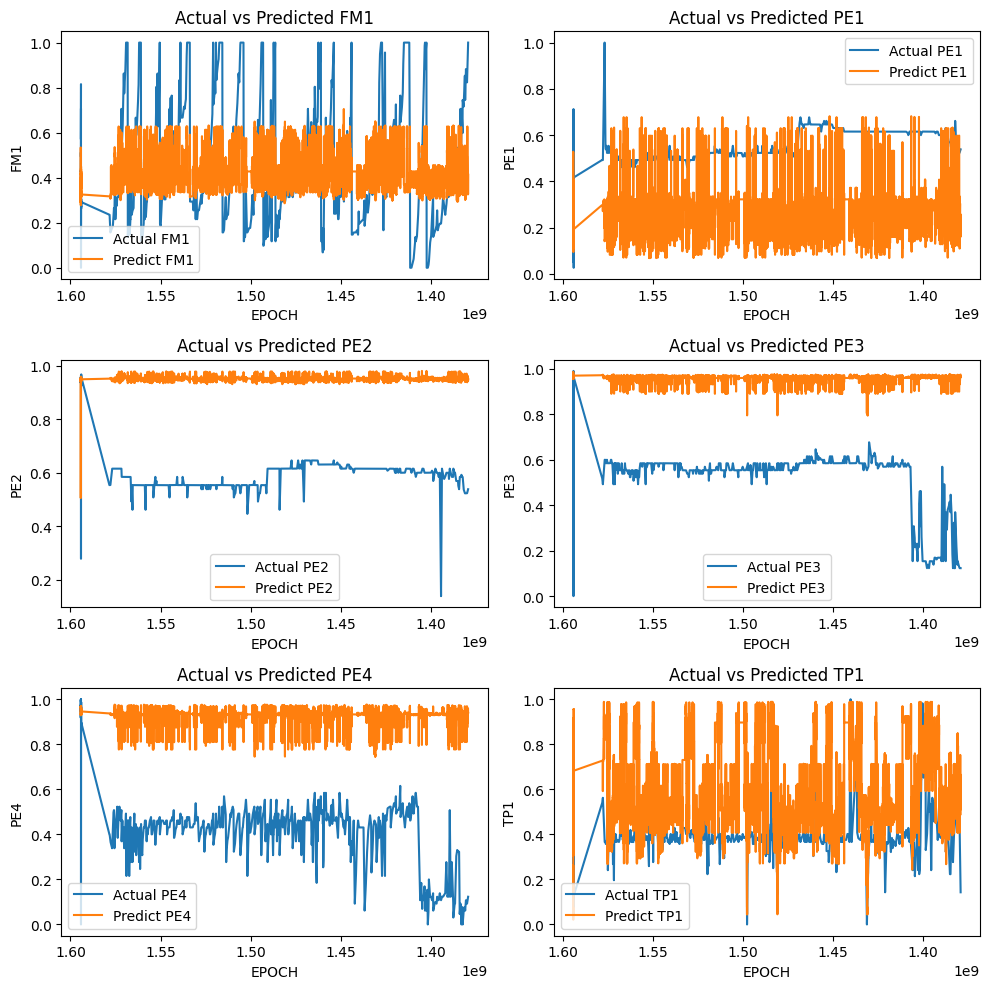


Metrics for FM1:
MSE: 0.072860
RMSE: 0.040984
R2: -0.088082
MAPE: 309317.12320375122362747788%
Good, RMSE 0.040984 less than or equal to 20%
Bad, R2 -0.088082 less than or equal to 80%

Metrics for PE1:
MSE: 0.106803
RMSE: 0.044762
R2: -27.315975
MAPE: 54.87134364460693802812%
Good, RMSE 0.044762 less than or equal to 20%
Bad, R2 -27.315975 less than or equal to 80%

Metrics for PE2:
MSE: 0.135612
RMSE: 0.021029
R2: -72.959825
MAPE: 63.38812893550821314648%
Good, RMSE 0.021029 less than or equal to 20%
Bad, R2 -72.959825 less than or equal to 80%

Metrics for PE3:
MSE: 0.205526
RMSE: 0.023666
R2: -11.717218
MAPE: 1736.83838348299832432531%
Good, RMSE 0.023666 less than or equal to 20%
Bad, R2 -11.717218 less than or equal to 80%

Metrics for PE4:
MSE: 0.298020
RMSE: 0.027323
R2: -17.354216
MAPE: 4371.64905698080747242784%
Good, RMSE 0.027323 less than or equal to 20%
Bad, R2 -17.354216 less than or equal to 80%

Metrics for TP1:
MSE: 0.082435
RMSE: 0.095741
R2: -11.491926
MAPE: 1298.5

In [ ]:
#concat and create one big dataset
data_all = pd.concat([data_manual, data_iiot])
data_all = data_all.sort_values(by='EPOCH', ascending=False)

# Define variables
dependent7y = ['FM1', 'PE1', 'PE2', 'PE3', 'PE4', 'TP1']
independent7y = 'TP2_smooth'

#split data_iiot part into train and test data, add epoch manual at test data
train_data7y = data_all[(data_all['EPOCH'] >= 1594339200) & (data_all['EPOCH'] <= 1595277000)]
test_data7y = data_all[(data_all['EPOCH'] >= 1379289600) & (data_all['EPOCH'] < 1594339200)]

#training and testing data random forest
x_train_random7y = train_data7y[independent7y].values.reshape(-1,1)
y_train_random7y = train_data7y[dependent7y]

x_test_random7y = test_data7y[independent7y].values.reshape(-1,1)
y_test_random7y = test_data7y[dependent7y]

#train random forest
modelrandomforest7y = RandomForestRegressor()
modelrandomforest7y.fit(x_train_random7y, y_train_random7y)

#predict & convert to DF
y_predict_random7y = modelrandomforest7y.predict(x_test_random7y)
y_predict_random7y = pd.DataFrame(y_predict_random7y, columns=dependent7y)

#create dictionary for error metrics
mse_random7y = {}
rmse_random7y = {}
r2_random7y = {}
mape_random7y = {}
epsilon = 1e-6 #use small number to avoid division of 0

#plot dependent variables seperately
plt.figure(figsize=(10,10))

for i, target7y in enumerate(dependent7y, 1):
  mse_random7y[target7y] = mean_squared_error(y_test_random7y[target7y], y_predict_random7y[target7y])
  rmse_random7y[target7y] = np.sqrt(mse_random7[target7y])
  r2_random7y[target7y] = r2_score(y_test_random7y[target7y], y_predict_random7y[target7y])

  error7y = np.abs(y_test_random7y[target7y] - y_predict_random7y[target7y])
  error_percent7y = (error7y/(y_test_random7y[target7y]+epsilon)*100)
  # Ensure no NaN values in MAPE calculation
  mape_random7y[target7y] = np.mean(error_percent7y)
  mape_random7y[target7y] = np.nan_to_num(np.mean(error_percent7y), nan=0.0)


  # plot actual vs predicted
  plt.subplot(3,2,i)
  plt.plot(test_data7y['EPOCH'], y_test_random7y[target7y], label=f'Actual {target7y}')
  plt.plot(test_data7y['EPOCH'], y_predict_random7y[target7y], label=f'Predict {target7y}')
  plt.xlabel('EPOCH')
  plt.ylabel(target7y)
  plt.title(f'Actual vs Predicted {target7y}')
  plt.gca().invert_xaxis()  # Reverse x-axis
  plt.legend()

plt.tight_layout()
plt.show()

#Print error metrics
for target7y in dependent7y:
  print(f'\nMetrics for {target7y}:')
  print(f'MSE: {mse_random7y[target7y]:.6f}')
  print(f'RMSE: {rmse_random7y[target7y]:.6f}')
  print(f'R2: {r2_random7y[target7y]:.6f}')
  print(f'MAPE: {mape_random7y[target7y]:.20f}%')

  if rmse_random7y[target7y] <= 0.2:
    print(f"Good, RMSE {rmse_random7y[target7y]:.6f} less than or equal to 20%")
  else:
    print(f"Bad, RMSE {rmse_random7y[target7y]:.6f} bigger than 20%")
  if r2_random7y[target7y] >= 0.8:
      print(f"Good, R2 {r2_random7y[target7y]:.6f} bigger than or equal to 80%")
  else:
    print(f"Bad, R2 {r2_random7y[target7y]:.6f} less than or equal to 80%")

We got good RMSE values, that explains the model generalizes well, but this can be result of overfitting. In the other hand, R2 is very bad because we got negative values, that means the model is worse than just a simple mean prediction. This occur because the data_manual have flunctuation and huge amount of outliers. What we can do to help this is tuning hyperparameters via n_estimators or randomforestregressor. We can try mapping the data_manual to other models to see the error metrics difference too. For the time being, we can conclude that the process area needs close monitoring to detect sensor failure and deviation. It would help alot if we can get baseline/control limits for all parameters and records of sensor failure (reading during failure).